Objective of this tutorial is to develop a Graph Neural Network based fradulent transaction detection model using a pulically available bitcoin transaction graph.

In [ ]:
import torch
import pdb

!pip uninstall torch-scatter torch-sparse torch-geometric  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor':'dimgrey', 'grid.color':'lightgrey'})

import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch_scatter
from torch_geometric.data import Data
print(torch.__version__)

# # The PyG built-in GCNConv
# from torch_geometric.nn import GCNConv
from torch_geometric.nn.conv import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_auc_score
import scipy.sparse as scsp
from sklearn.cluster import KMeans
import copy

1.13.0+cu116


#Elliptic Dataset 

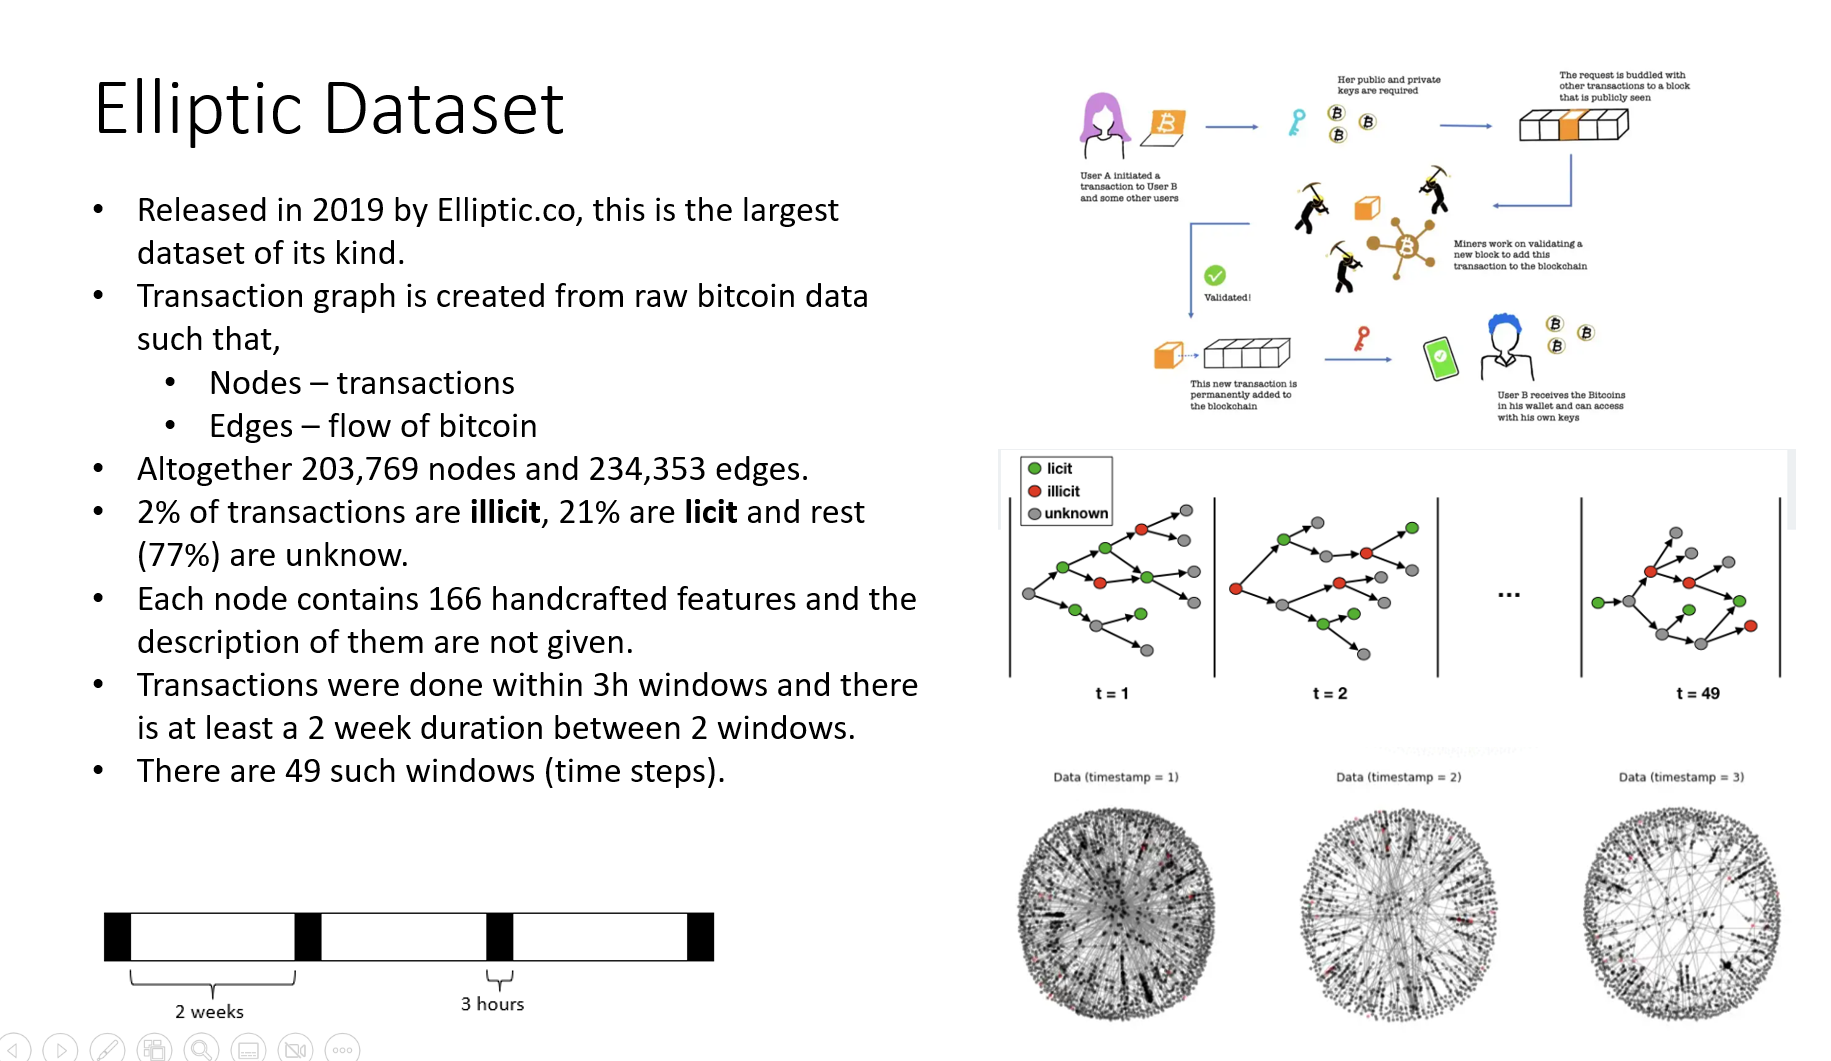

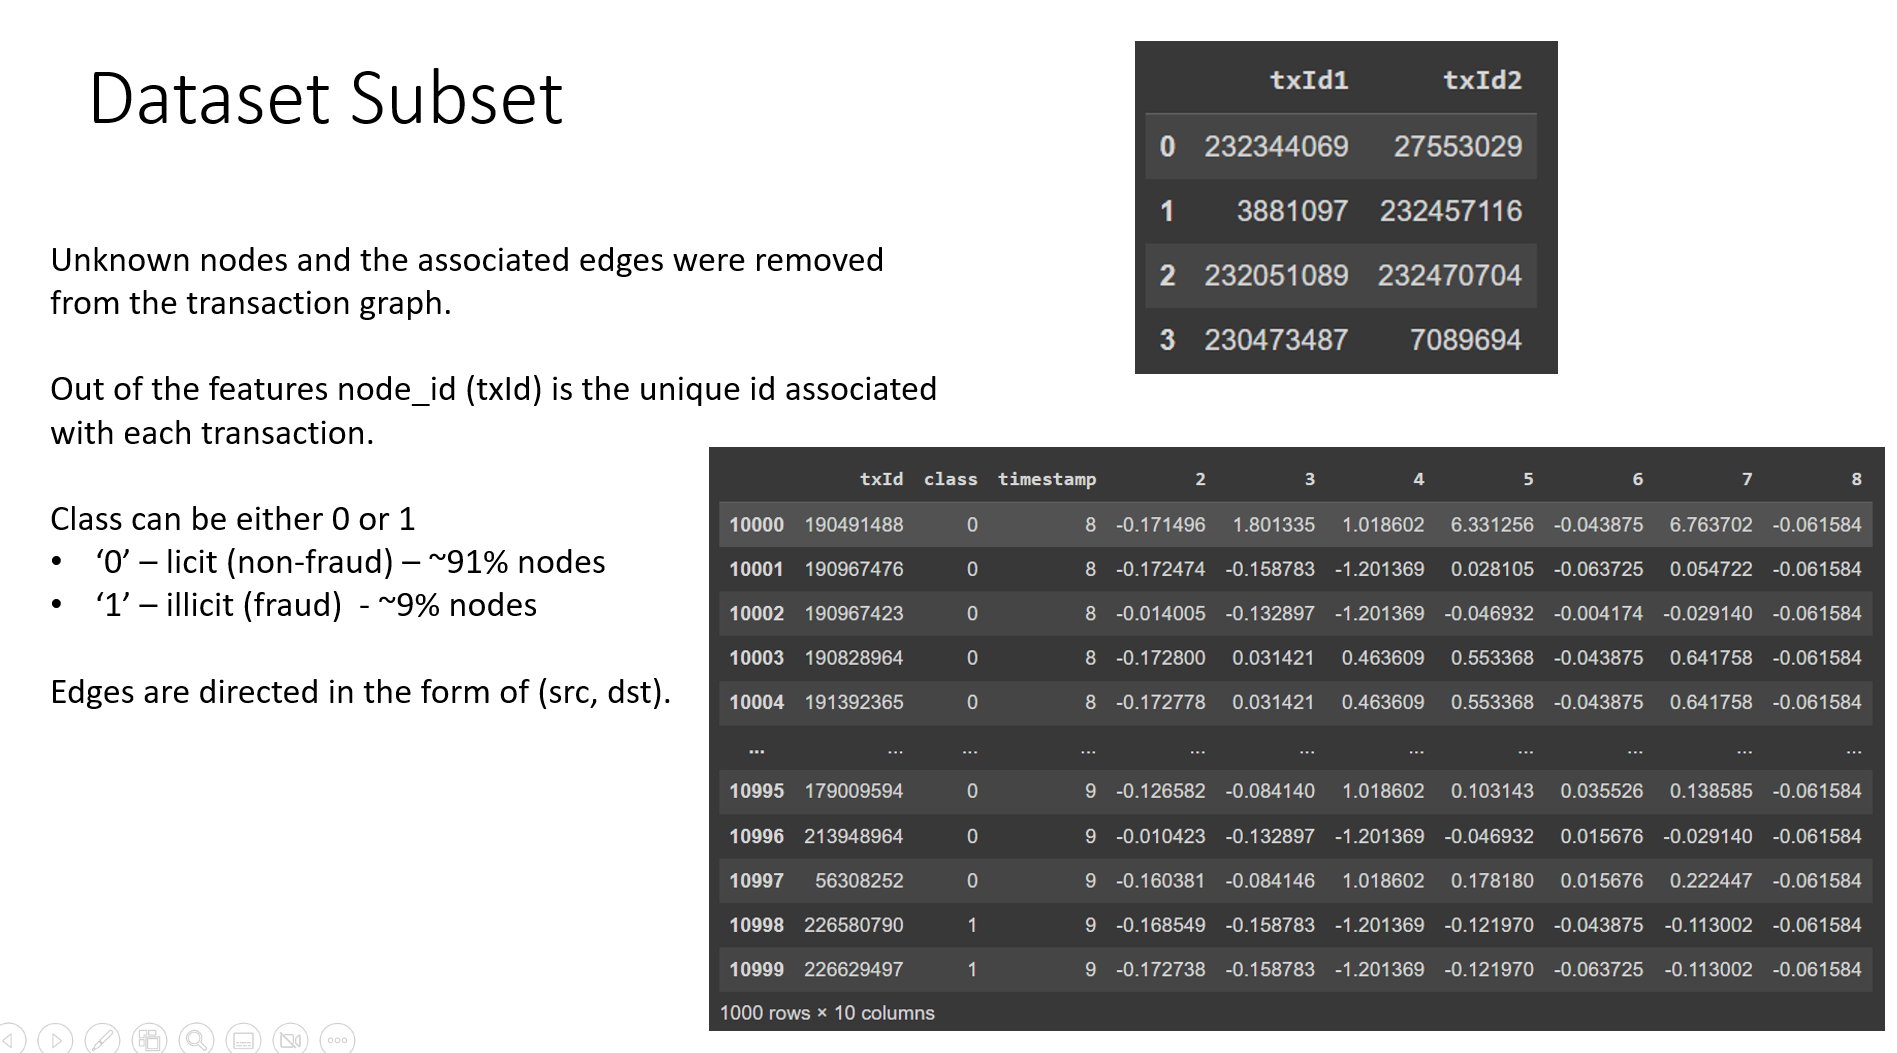

In [ ]:
url_data_e = (r'https://raw.githubusercontent.com/yuchenWYC/', r'Elliptic_dataset/master/edges.csv')
edges = pd.read_csv(url_data_e)

url_data_n = (r'https://media.githubusercontent.com/media/yuchenWYC/'
              r'Elliptic_dataset/master/nodes.csv')
nodes = pd.read_csv(url_data_n)

In [ ]:
#this only contains the nodes and edges of licit and illicit labeled data
print(nodes.shape) 
print(edges.shape)

(46564, 168)
(36624, 2)


We can take a look at how the preprocessed dataset looks like.

In [ ]:
nodes.iloc[:5, 0:10]

,txId,class,timestamp,2,3,4,5,6,7,8
0,232438397,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558
1,232029206,0,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305
2,232344069,0,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584
3,27553029,0,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584
4,3881097,0,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712


In [ ]:
edges.head()

,txId1,txId2
0,232344069,27553029
1,3881097,232457116
2,232051089,232470704
3,230473487,7089694
4,231182296,14660781


# Time-Step Splitting Script



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device in use: ', device)

device in use:  cpu


Graph basic analysis and time-step base splitting

In [ ]:
new_nodes=nodes
new_edges=edges

#pandas -> numpy -> pytorch tensors
features =  torch.FloatTensor(new_nodes.iloc[:, 2:].to_numpy()) #contains from timestep - final feature , float32
times = new_nodes.iloc[:, 2].to_numpy() 
times = torch.LongTensor(times.reshape(len(times),)) #int64 ,shape is (46564)
labels = new_nodes.iloc[:, 1].to_numpy()
labels = torch.LongTensor(labels.reshape(len(labels),))#int64 ,shape is (46564)

nodes_id = new_nodes.iloc[:, 0].to_numpy()
nodes_id = torch.LongTensor(nodes_id.reshape(len(nodes_id),))#int64 ,shape is (46564)

min_t = torch.min(times) # 1
max_t = torch.max(times) # 49

In [ ]:
features.shape

torch.Size([46564, 166])

In [ ]:
#check if the nodes are indeed unique
num_of_uid=nodes_id.numpy().shape[0]
assert num_of_uid==np.unique(nodes_id.numpy()).shape[0]

print(nodes_id[:10]) #example values

tensor([232438397, 232029206, 232344069,  27553029,   3881097, 232457116,
        232412405, 232470342, 230550393, 232051089])


In [ ]:
#check if there is only 49 times steps
unique_time_steps=np.unique(times.numpy())
print('Times steps in dataset: ',unique_time_steps)
assert 49==unique_time_steps.shape[0]

Times steps in dataset:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]


In [ ]:
#check the labels of the dataset
labels.shape
unique_labels=np.unique(labels.numpy())
print('labels: ',unique_labels)

labels:  [0 1]


In [ ]:
#check the node label distribution - label '1' for illicit an label '0' for licit 
unique_labels=np.unique(labels.numpy(), return_counts=True)
print('labels with count: ',unique_labels)
licit_n=unique_labels[1][0]
illicit_n=unique_labels[1][1]
num_of_n=nodes.shape[0]
print('number of licit nodes:', licit_n, 'precentage : {:.2f}%'.format((licit_n/num_of_n)*100)  ) #legitimate transactions
print('number of illicit nodes:', illicit_n, 'precentage : {:.2f}%'.format((illicit_n/num_of_n)*100)  ) #fradulent transactions

labels with count:  (array([0, 1]), array([42019,  4545]))
number of licit nodes: 42019 precentage : 90.24%
number of illicit nodes: 4545 precentage : 9.76%


In [ ]:
type([times == 1][0])

torch.Tensor

In [ ]:
# Construct nodes of the directed graph for each time step;
# features by time step are stored in "features_t"; labels by
# time step are stored in "labels_t"
features_t = []
labels_t = []

nodes_subgraph_t=[]
# Create a dictionary where
# <key, value> = <node_id, <<idx, node_index_in_time_t_subgraph>, <t, time_t>>>.
id2idx = {}
for t in range(min_t, max_t + 1):
    features_t.append(features[times == t, :]) #imes == t result in a list of True and False; True when times values are ==t
    labels_t.append(labels[times == t])
    nodes_t = nodes_id[times == t]
    nodes_subgraph_t.append(nodes_t.shape[0]) #newly added to get the num of nodes in each time step
    for i in range(nodes_t.shape[0]):
        id2idx[nodes_t[i].item()] = {} #item() gives the value as a int/float; if item() not used then result in a tensor
        id2idx[nodes_t[i].item()]['idx'] = i #this is the index within the subgraph ; relates to features index and labels index 
        id2idx[nodes_t[i].item()]['t'] = t #this is the one used to identify the subgraph

#example id2idx:.....(160941665, {'idx': 226, 't': 49}), (157908414, {'idx': 227, 't': 49})....

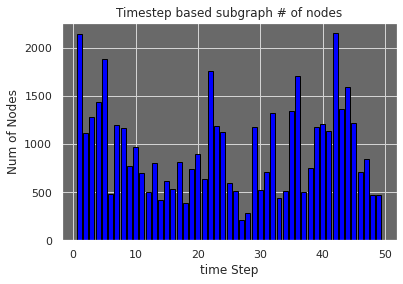

In [ ]:
# plot the time step based subgraphs' number of nodes 
x = list(range(1, 50))
y = nodes_subgraph_t

plt.bar(x, y,color='blue', edgecolor='black')

plt.title("Timestep based subgraph # of nodes")
plt.xlabel("time Step")
plt.ylabel("Num of Nodes")

plt.show()

In [ ]:
# Construct adjacency lists of the directed graph (non-symmetric) for each time step;
# adjacency lists for each time step are stored in "edge_indices".
edge_idx_t = [[] for _ in range(min_t, max_t + 1)]
for index in range(new_edges.shape[0]):   
    node1_t = id2idx[new_edges.iloc[index, 0]]['t']
    node1_idx = id2idx[new_edges.iloc[index, 0]]['idx']
    node2_t = id2idx[new_edges.iloc[index, 1]]['t']
    node2_idx = id2idx[new_edges.iloc[index, 1]]['idx']
    edge_idx_t[node1_t - 1].append([node1_idx, node2_idx]) # since time_step starts from 1

    assert node1_t==node2_t #checks there are no edges between different timestep based subgraphs

edge_indices = [torch.LongTensor(edge_idx_t[i]).t() for i in range(len(edge_idx_t))]


In [ ]:
#edge_indices  distribution ; edges are directed 
print(edge_idx_t[0][:10]) #example of edge list for timestep==1
print(edge_indices[0].shape)
print(edge_indices[0])

[[2, 3], [4, 5], [9, 10], [12, 13], [19, 20], [21, 22], [27, 28], [30, 31], [33, 34], [36, 37]]
torch.Size([2, 1924])
tensor([[   2,    4,    9,  ..., 1503, 1220, 1149],
        [   3,    5,   10,  ...,  307, 1622,  763]])


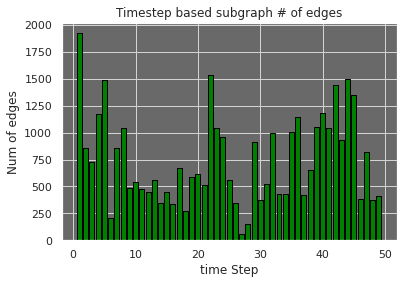

In [ ]:
# plot the time step based subgraphs' number of edges 
edges_subgraph_t=[edges.shape[1] for edges in edge_indices ]

x = list(range(1, 50))
y = edges_subgraph_t

plt.bar(x, y,color='green', edgecolor='black')

plt.title("Timestep based subgraph # of edges")
plt.xlabel("time Step")
plt.ylabel("Num of edges")

plt.show()

Time-step base splitting as a function

In [ ]:
def time_step_split_helper(new_nodes, new_edges):
    """
    Creating subgraphs that only contains the transactions related to that time step (i.e., all those transacations happen within 3h) 
    Split the graph and store node features, edges (represented by adjacency list),
    and labels separately by timestamp t (from 1 to 49).

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list

    Returns:
        features_t    A list of (|N_t|, d) feature matrices by timestamp
        edge_indices  A list of (2, |E_t|) adjacency list by timestamp
        labels_t      A list of (|N_t|) labels by timestamp
    """

    features =  torch.FloatTensor(new_nodes.iloc[:, 2:].to_numpy()) #contains from timestep - final feature
    times = new_nodes.iloc[:, 2].to_numpy() 
    times = torch.LongTensor(times.reshape(len(times),))
    labels = new_nodes.iloc[:, 1].to_numpy()
    labels = torch.LongTensor(labels.reshape(len(labels),))

    nodes_id = new_nodes.iloc[:, 0].to_numpy()
    nodes_id = torch.LongTensor(nodes_id.reshape(len(nodes_id),))

    min_t = torch.min(times) # 1
    max_t = torch.max(times) # 49
    
    features_t = []
    labels_t = []
    
    id2idx = {}
    for t in range(min_t, max_t + 1):
        features_t.append(features[times == t, :])
        labels_t.append(labels[times == t])
        nodes_t = nodes_id[times == t]
        for i in range(nodes_t.shape[0]):
            id2idx[nodes_t[i].item()] = {}
            id2idx[nodes_t[i].item()]['idx'] = i
            id2idx[nodes_t[i].item()]['t'] = t

    edge_idx_t = [[] for _ in range(min_t, max_t + 1)]
    for index in range(new_edges.shape[0]):   
        node1_t = id2idx[new_edges.iloc[index, 0]]['t']
        node1_idx = id2idx[new_edges.iloc[index, 0]]['idx']
        node2_t = id2idx[new_edges.iloc[index, 1]]['t']
        node2_idx = id2idx[new_edges.iloc[index, 1]]['idx']
        edge_idx_t[node1_t - 1].append([node1_idx, node2_idx]) 

    edge_indices = [torch.LongTensor(edge_idx_t[i]).t() for i in range(len(edge_idx_t))] 
    #transpose was taken so it agrees with PyG Data object required shape
    
    return features_t, edge_indices, labels_t 
    #returns lists containing features , edges and labels for each timestep subgraph

Train, Validation and Test Dataset

In [ ]:
train_lt = 31
val_lt = 36
test_lt = 49
new_nodes=nodes
new_edges=edges

features_t, edge_indices, labels_t = time_step_split_helper(new_nodes, new_edges)

graph_info = np.zeros((len(labels_t), 4), dtype = np.int64) # (49,4)

for t in range(len(labels_t)):
    graph_info[t, :] = np.array([t, features_t[t].shape[0], edge_indices[t].shape[1],
                                  labels_t[t][labels_t[t] == 1].shape[0]])

In [ ]:
print(graph_info[10]) #  [timestep (start fr 0), num_n, num_edge, num_illicit_nodes]

[ 10 696 477 131]


In [ ]:
train_idx, val_idx, test_idx = [np.arange(train_lt), np.arange(train_lt, val_lt),
                                np.arange(val_lt, test_lt)] 

print(train_idx) #train : 0-30
print(val_idx) #val : 31-35
print(test_idx) #test : 36-48

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
[31 32 33 34 35]
[36 37 38 39 40 41 42 43 44 45 46 47 48]


In [ ]:
train_idx, val_idx, test_idx = [np.arange(train_lt), np.arange(train_lt, val_lt),
                                np.arange(val_lt, test_lt)]
train_list = [Data(x = features_t[idx], edge_index = edge_indices[idx],
                    y = labels_t[idx]).to(device) for idx in train_idx ] #list of Data objects for each timestep
val_list = [Data(x = features_t[idx], edge_index = edge_indices[idx],
                  y = labels_t[idx]).to(device) for idx in val_idx ]
test_list = [Data(x = features_t[idx], edge_index = edge_indices[idx],
                  y = labels_t[idx]).to(device) for idx in test_idx ]
data = {}
data['train'] = train_list
data['val'] = val_list
data['test'] = test_list

In [ ]:
print(type(data['test'][0]))
print(data['test'][0]) #shows the shape of each Feature matrix, Edge matrix and Lable vector

<class 'torch_geometric.data.data.Data'>
Data(x=[498, 166], edge_index=[2, 423], y=[498])


Train, Validation and Test Dataset as a fuction

In [ ]:
def time_step_split(new_nodes, new_edges, device, train_lt = 31, val_lt = 36, test_lt = 49):
    """
    Create and return the training, validation, and test set, splitted by time step,
    where each subgraph at time t is considered as an input of GCN model.

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list
        device        Computing device
        train_lt      The last time step index of training set
        val_lt        The last time step index of validation set
        test_lt       The last time step index of test set

    Returns:
        data          A dictionary that stores training, validation, and test set,
                        each value is a list of Data object
        graph_info    A matrix where each row contains information of the time-step subgraph
                      [time_step, num_of_nodes, num_of_edges, num_of_illicit_nodes]
    """
    features_t, edge_indices, labels_t = time_step_split_helper(new_nodes, new_edges)

    graph_info = np.zeros((len(labels_t), 4), dtype = np.int64)
    for t in range(len(labels_t)):
        graph_info[t, :] = np.array([t, features_t[t].shape[0], edge_indices[t].shape[1],
                                     labels_t[t][labels_t[t] == 1].shape[0]])

    train_idx, val_idx, test_idx = [np.arange(train_lt), np.arange(train_lt, val_lt),
                                    np.arange(val_lt, test_lt)]
    train_list = [Data(x = features_t[idx], edge_index = edge_indices[idx],
                       y = labels_t[idx]).to(device) for idx in train_idx ]
    val_list = [Data(x = features_t[idx], edge_index = edge_indices[idx],
                     y = labels_t[idx]).to(device) for idx in val_idx ]
    test_list = [Data(x = features_t[idx], edge_index = edge_indices[idx],
                      y = labels_t[idx]).to(device) for idx in test_idx ]
    data = {}
    data['train'] = train_list
    data['val'] = val_list
    data['test'] = test_list

    return data, graph_info

PyTorch Geometric Data Class
link : https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html

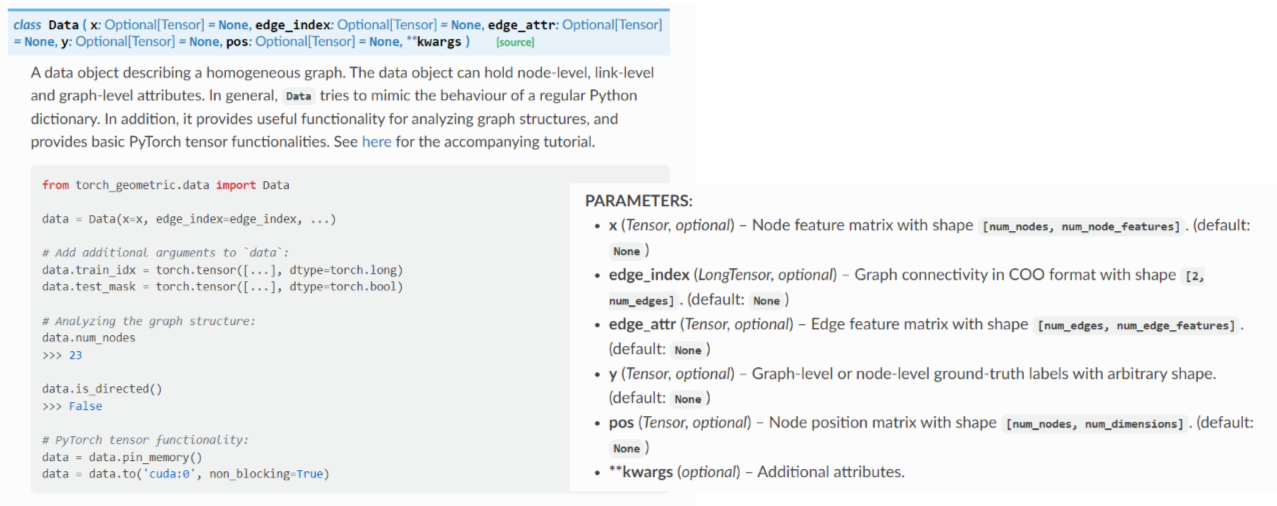

In [ ]:
data, graph_info = time_step_split(nodes, edges, device)
for key in data:
  print(key, len(data[key])) #each data[key] is a list containing each timestep

train 31
val 5
test 13


GCN Model Initialization

GCN layers were built by extending the PyG MessagePassing Class
link: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

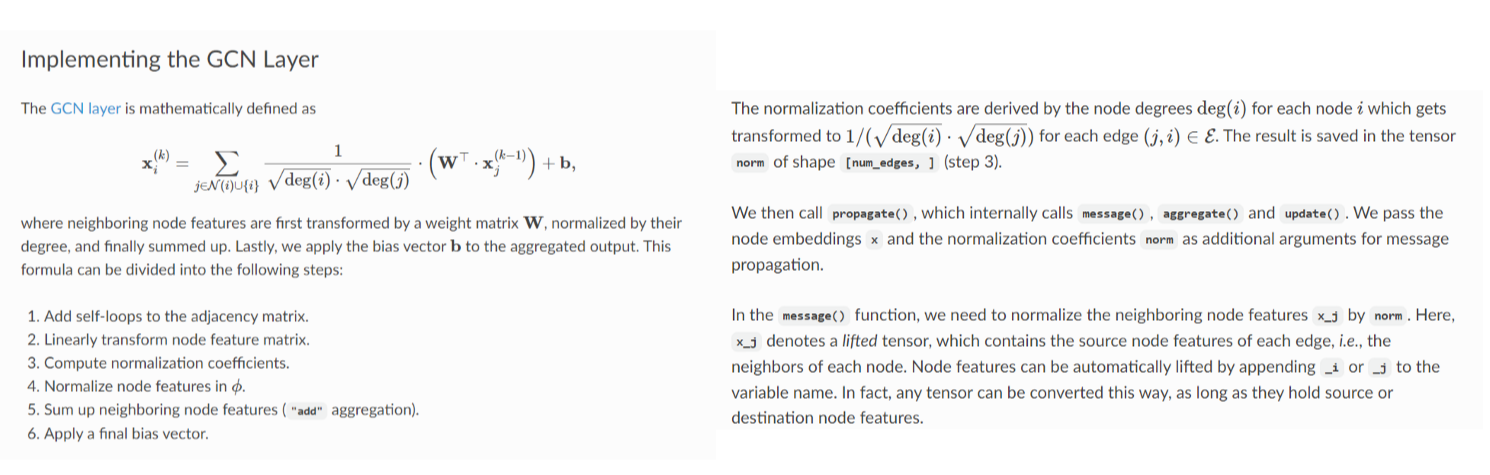

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds = False):
        """
        Initialize a GCN model.
        Args:
            input_dim       Input dimension of node embeddings
            hidden_dim      Hidden dimension of node embeddings
            output_dim      Output dimension of node embeddings
            num_layers      The number of GCN layers
            dropout         The dropout ratio in (0, 1]
                              (dropout: the probability of an element getting zeroed)
            return_embeds   A boolean value determining whether we skip the
                              classification layer and return node embeddings
        """
        #initialize the Module class
        super(GCN, self).__init__() 

        # Construct all convs
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList([GCNLayer(hidden_dim, hidden_dim, directed = False) 
                                                        for i in range(self.num_layers-1)]) #all GCN layers

        # Construct batch normalization
        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim)
                                        for i in range(self.num_layers-1)]) #all BN layers
        # First GCN layer
        self.convs[0] = GCNLayer(input_dim, hidden_dim, directed = False)
        # Last GCN layer
        self.last_conv = GCNLayer(hidden_dim, output_dim, directed = False)
        self.softmax = torch.nn.LogSoftmax(dim = -1)
        
        self.dropout = dropout
        self.return_embeds = return_embeds

    def reset_parameters(self):
        """
        Reset all learnable parameters in GCN layers and Batch Normalization
        Layers.
        """
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        """
        Produce a forward propagation of GCN model. Before the last GCN layer,
        we transform the embedding (x) in the following sequence:
          x -> GCN_Layer -> Batch_Norm -> ReLU -> Dropout.
        At the last GCN layer, the following sequence is applied:
          x -> GCN Layer -> Softmax -> output.
        
        Args:
            x             The node embedding
            edge_index    The adjacency list of the graph
        
        Returns:
            out           The predictions of labels / the updated node embedding
        """
        x = torch.clone(x.detach())
        for l in range(self.num_layers - 1):
            # Unweighted graph has weight 1; since edges doesn't carry any other information 
            x = self.convs[l](x, edge_index, torch.ones(edge_index.shape[1]))
            x = self.bns[l](x)
            x = F.relu(x) # x is the (hidden) embedding - > non linearity 
            x = F.dropout(x, p = self.dropout, training = self.training)  #need training =True/Flase since using F.dropout
                                                                          #randomly zero the embeddings - 
                                                                          #since large graph it act as a regularization method

        x = self.last_conv(x, edge_index, torch.ones(edge_index.shape[1]))
        if self.return_embeds:
            out = x
        else:
            out = self.softmax(x) # probability for each prediction

        return out

In [ ]:
class GCNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, bias = True, 
                 directed = False, self_loop = True, **kwargs):
        """
        Initialize a GCN layer.
        Args:
            in_channels      In-channel dimension of node embeddings
            out_channels     Out-channel dimension of node embeddings
            bias             A boolean value determining whether we add a
                                learnable bias term in linear transformation
            directed         A boolean value determining whether we use directed
                                message passing D^{-1}A or use symmetric normalized
                                adjacency matrix D^{-1/2}AD^{-1/2}
            self_loop        A boolean value determining whether we add a self-
                                loop for each node
        """
        super(GCNLayer, self).__init__(**kwargs, aggr = 'add')

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.directed = directed
        self.self_loop = self_loop

        # Define the layers needed for the message and update functions below.
        # self.lin is the linear transformation that we apply to the embedding.
        self.lin = nn.Linear(self.in_channels, self.out_channels, bias = bias)
        
        self.reset_parameters()

    def reset_parameters(self):
        """
        Reset all learnable parameters in the linear transformation.
        """
        self.lin.reset_parameters()

    def forward(self, x, edge_index, edge_weight):
        """
        Produce a forward propagation of GCN layer.
        
        Args:
            x             The node embedding
            edge_index    The (2, |E|) adjacency list of the graph
            edge_weight   The (|E|) vector specifying the edge weights in the graph
                            (for unweighted graph, edge weight is 1)
        
        Returns:
            An updated node embedding
        """
        
        # Add self-loops to the adjacency matrix.
        if self.self_loop:
            edge_index, _ = add_self_loops(edge_index, num_nodes = x.size(0))
            edge_weight = torch.cat((edge_weight, torch.ones(x.size(0))), dim = -1)
            
        
        # Apply linear transformation on node features.
        x = self.lin(x)

        # Compute normalization by updated node degree.
        if self.directed: 
            row , _ = edge_index
            deg = degree(row, x.size(0), dtype = x.dtype) 
            deg_inv = deg.pow(-1)
            deg_inv[deg_inv == float('inf')] = 0
            norm = deg_inv[row]
        else:
            row, col = edge_index
            
            deg = degree(col, x.size(0), dtype = x.dtype) #tensor; outward edges only considered for degree 
            deg_inv_sqrt = deg.pow(-0.5)
            deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0 #when degree is zero /  leaf nodes / sel loop removes this
            norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
            # pdb.set_trace()

        return self.propagate(edge_index, x = (x, x), norm = norm, edge_weight = edge_weight)

    def message(self, x_j, edge_weight, norm):
        """
        Send the message of the neighboring node (i.e., x_j) to the source node (i.e., x_i).
        
        Args:
            x_j           The embedding of the neighboring node of source node x_i
            edge_weight   The edge weight of certain edge
            norm          Normalization constant determined by self.directed
        
        Returns:
            A message sending from the neighboring node to the source node
        """
        return norm.view(-1, 1) * x_j * edge_weight.view(-1, 1)

Train and Test iterations

In [ ]:
def train_ind_time_step(model, train_data, optimizer, loss_fn):
    """
    Train the model by using the given optimizer and loss_fn.
    
    Args:
        model       The GCN model
        train_data  The Data object that stores x, edge_index, and labels
                      only for training set
        optimizer   The optimizer
        loss_fn     The loss function

    Returns
        The average prediction loss of each time step in the training set
          by the given loss function
    """
    model.train()
    loss = torch.FloatTensor([0]*len(train_data)).to(device)
    optimizer.zero_grad()
    for i, data_t in enumerate(train_data):
        train_slice = model.forward(data_t.x, data_t.edge_index)
        train_label = data_t.y
        loss[i] = loss_fn(train_slice, train_label)
    loss.mean().backward()
    optimizer.step()
    return loss.mean().item()

In [ ]:
@torch.no_grad()
def test_ind_time_step(model, data, save_model_results=False):
    """
    Test the model by using the given splitted datasets.

    Args:
        model                 The GCN model
        data                  A dictionary of Data objects that store x, edge_index, and labels
                                for three sets
        save_model_results    A boolean determining whether we save the model results

    Returns
        The accuracy and auc-roc score of training, validation, and test set
    """

    model.eval()
    # The output of model on each data sets
    eval = {}
    for name in data.keys():
        data_list = data[name]
        eval_report = []
        eval_auc_roc = 0
        for i,data_i in enumerate(data_list):
            out = model.forward(data_i.x, data_i.edge_index)
            y_pred = out.argmax(dim=-1, keepdim=True)
            acc = classification_report(torch.unsqueeze(data_i.y, -1),
                                        y_pred,output_dict=True, zero_division=0)
            eval_report.append(acc)
            auc_roc = roc_auc_score(torch.unsqueeze(data_i.y, -1),y_pred)
            eval_auc_roc += auc_roc
        report = {}
        for key in eval_report[0].keys():
            if type(eval_report[0][key]) is dict:
                df = pd.DataFrame([sub_report[key] for sub_report in eval_report])
                report[key] = df.mean().to_dict()
            else:
                report[key] = np.mean(np.array([sub_report[key] for sub_report in eval_report]))
        eval_auc_roc /= len(data_list)
        eval[name] = {'report': pd.DataFrame(report), 'auc_roc': eval_auc_roc}
    
    if save_model_results:
        print ("Saving Model Predictions")

        data_new = {}
        data_new ['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

        df = pd.DataFrame(data=data_new )
        # Save locally as csv
        df.to_csv('gcn_ind.csv', sep=',', index=False)
    
    return eval['train']['report'], eval['val']['report'], eval['test']['report'], \
           eval['train']['auc_roc'], eval['val']['auc_roc'], eval['test']['auc_roc']

In [ ]:
args = {
    'device': device,
    'num_layers': 2,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 50,
    'label_weight': torch.Tensor([0.5, 0.5])
}
args

{'device': 'cpu',
 'num_layers': 2,
 'hidden_dim': 256,
 'dropout': 0.5,
 'lr': 0.01,
 'epochs': 50,
 'label_weight': tensor([0.5000, 0.5000])}

In [ ]:
#chnaged for testing
args = {
    'device': device,
    'num_layers': 2,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 5,
    'label_weight': torch.Tensor([0.5, 0.5])
}
args

{'device': 'cpu',
 'num_layers': 2,
 'hidden_dim': 256,
 'dropout': 0.5,
 'lr': 0.01,
 'epochs': 5,
 'label_weight': tensor([0.5000, 0.5000])}

Model training and evaluation

In [ ]:
model = GCN(data['train'][0].x.shape[1], args['hidden_dim'],
            2, args['num_layers'], args['dropout']).to(device)

In [ ]:
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.NLLLoss(weight=args['label_weight'])

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + args["epochs"]):
    # train with random split
    loss = train_ind_time_step(model, data['train'], optimizer, loss_fn)
    losses.append(loss)
    result = test_ind_time_step(model, data)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result 
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(model)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]

    print('Epoch: {:02},'.format(epoch),
          'Loss:{:.4f}'.format(loss),
          'Train:\n{}\n'.format(train_acc),
          'Train_auc_roc: {}'.format(train_auc),
          '\n\n'
          'Valid:\n{}\n'.format(val_acc),
          'Val_auc_roc: {}'.format(val_auc),
          '\n\n'
          'Test:\n{}\n'.format(test_acc),
          'Test_auc_roc: {}'.format(test_auc),
          '\n'
          )


Other Implementations Methods

In [ ]:
def time_group_split(new_nodes, new_edges, device, train_lt = 31, val_lt = 36, test_lt = 49):
    """
    Create and return the training, validation, and test set, splitted by specific
    time step intervals, where the combination of subgraphs within the time step
    interval is considered as an input of GCN model.

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list
        device        Computing device
        train_lt      The last time step index of training set
        val_lt        The last time step index of validation set
        test_lt       The last time step index of test set

    Returns:
        data          A dictionary that stores training, validation, and test set
                        each value is one Data object
    """
    features =  torch.FloatTensor(new_nodes.iloc[:, 2:].to_numpy())
    times = new_nodes.iloc[:, 2].to_numpy()
    times = torch.LongTensor(times.reshape(len(times),))
    labels = new_nodes.iloc[:, 1].to_numpy()
    labels = torch.LongTensor(labels.reshape(len(labels),))

    nodes_id = new_nodes.iloc[:, 0].to_numpy()
    nodes_id = torch.LongTensor(nodes_id.reshape(len(nodes_id),))
    train_idx, val_idx, test_idx = [np.arange(1, train_lt + 1),
                                    np.arange(train_lt + 1, val_lt + 1),
                                    np.arange(val_lt + 1, test_lt + 1)]
    data_names = {'train': train_idx, 'val': val_idx, 'test': test_idx}
    
    # Construct nodes of the directed graph for specific time step intervals.
    # Features are stored in the given dataset name (train/val/test) of a dictionary,
    # 'raw_data', with key "features"; labels are stored with key "labels".
    min_t = torch.min(times) # 1
    max_t = torch.max(times) # 49

    id2idx = {}
    raw_data = {}
    for name in data_names.keys():
        features_set = []
        labels_set = []
        Id_set = []
        set_index = data_names[name]
        for time in set_index:
            features_set.append(features[times == time, :])
            labels_set.append(labels[times == time])
            Id_set.append(nodes_id[times == time])
        features_set = torch.cat(features_set, 0)
        labels_set = torch.cat(labels_set, 0)
        Id_set = torch.cat(Id_set, 0)
        for i in range((Id_set).shape[0]):
            id2idx[Id_set[i].item()] = {}
            id2idx[Id_set[i].item()]['idx'] = i
            id2idx[Id_set[i].item()]['set_name'] = name
        raw_data[name] = {'features': features_set, 'labels': labels_set}


    # Construct adjacency lists of the directed graph (non-symmetric) for
    # specific time intervals. Adjacency lists are stored with key "edge_indices".
    edge_idx_set = {name: [] for name in data_names.keys()}
    for index in range(new_edges.shape[0]): 
        node1_set = id2idx[new_edges.iloc[index, 0]]['set_name']
        node1_idx = id2idx[new_edges.iloc[index, 0]]['idx']
        node2_set = id2idx[new_edges.iloc[index, 1]]['set_name']
        node2_idx = id2idx[new_edges.iloc[index, 1]]['idx']
        edge_idx_set[node1_set].append([node1_idx, node2_idx]) # time_stamp starts from 1

    for name in data_names.keys():
        raw_data[name]['edge_indices'] = torch.LongTensor(edge_idx_set[name]).t()


    # Construct the training, validation, test set by 'raw_data' and store
    # in a dictionary, 'data'.
    data = {}
    for name in data_names.keys():
        data[name] = Data(x = raw_data[name]['features'],
                          edge_index = raw_data[name]['edge_indices'],
                          y = raw_data[name]['labels']).to(device)
    return data

In [ ]:
data2 = time_group_split(nodes, edges, device)
data2

{'train': Data(x=[27615, 166], edge_index=[2, 21045], y=[27615]),
 'val': Data(x=[5328, 166], edge_index=[2, 4003], y=[5328]),
 'test': Data(x=[13621, 166], edge_index=[2, 11576], y=[13621])}

# Random Splitting Script


In [ ]:
def random_split_transd(new_nodes, new_edges, train_size, test_size, device, seed = 42):
    """
    Create and return the training, validation, and test set by randomly splitting
    the node indices to these three sets. Keep edge_index known for all sets.

    Args:
        new_nodes     A dataframe of the node features
        new_edges     A dataframe of the graph's adjacency list
        train_size    The node size proportion in training set
        test_size     The node size proportion in test set
        device        Computing device
        seed          Random seed for data splitting

    Returns:
        data          A Data object that stores node features, edge_index, and labels
        dict          A dictionary that stores training, validation, test set node indices
    """
    features =  torch.FloatTensor(new_nodes.iloc[:, 2:].to_numpy())
    labels = new_nodes.iloc[:, 1].to_numpy()
    labels = torch.LongTensor(labels.reshape(len(labels),))
    nodes_id = new_nodes.iloc[:, 0].to_numpy()

    # Create a dictionary that maps nodeId to index in the dataframe.
    id2idx = {}
    for i in range(new_nodes.shape[0]):
        id2idx[new_nodes.iloc[i, 0]] = i

    # Construct edge_index with same node indexing as in features and labels
    edge_idx = np.zeros((2, new_edges.shape[0]), dtype = np.int64)
    for index in range(new_edges.shape[0]):   
        node1 = id2idx[new_edges.iloc[index, 0]]
        node2 = id2idx[new_edges.iloc[index, 1]]
        edge_idx[:, index] = [node1, node2]
    edge_index = torch.LongTensor(edge_idx)

    train_index, test_index = train_test_split(np.arange(labels.shape[0]),
                                               test_size = 1 - train_size,
                                               random_state = 42)
    val_index, test_index = train_test_split(test_index,
                                             test_size = test_size / (1 - train_size),
                                             random_state = 42)

    # Construct the training, validation, test set and store
    # in a dictionary, 'data'.
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    data = Data(x = features, edge_index = edge_index, y = labels).to(device)
                  
    return data, {'train': train_index, 'val': val_index, 'test': test_index}

In [ ]:
node_sum = nodes.shape[0]
train_node_size = np.sum(graph_info[0: 31, 1]) / node_sum
test_node_size = np.sum(graph_info[36:, 1]) / node_sum
data3, split_idx3 = random_split_transd(nodes, edges, train_size = train_node_size,
                                        test_size = test_node_size, device = device)
data3

Data(x=[46564, 166], edge_index=[2, 36624], y=[46564])

In [ ]:
train_node_size, test_node_size

(0.5930547203848466, 0.29252212009277556)

# GCN Model

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds = False):
        """
        Initialize a GCN model.
        Args:
            input_dim       Input dimension of node embeddings
            hidden_dim      Hidden dimension of node embeddings
            output_dim      Output dimension of node embeddings
            num_layers      The number of GCN layers
            dropout         The dropout ratio in (0, 1]
                              (dropout: the probability of an element getting zeroed)
            return_embeds   A boolean value determining whether we skip the
                              classification layer and return node embeddings
        """

        super(GCN, self).__init__()

        # Construct all convs
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList([GCNLayer(hidden_dim, hidden_dim, directed = False) 
                                                        for i in range(self.num_layers-1)])

        # Construct batch normalization
        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim)
                                        for i in range(self.num_layers-1)])
        # First GCN layer
        self.convs[0] = GCNLayer(input_dim, hidden_dim, directed = False)
        # Last GCN layer
        self.last_conv = GCNLayer(hidden_dim, output_dim, directed = False)
        self.softmax = torch.nn.LogSoftmax(dim = -1)
        
        self.dropout = dropout
        self.return_embeds = return_embeds

    def reset_parameters(self):
        """
        Reset all learnable parameters in GCN layers and Batch Normalization
        Layers.
        """
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        """
        Produce a forward propagation of GCN model. Before the last GCN layer,
        we transform the embedding (x) in the following sequence:
          x -> GCN_Layer -> Batch_Norm -> ReLU -> Dropout.
        At the last GCN layer, the following sequence is applied:
          x -> GCN Layer -> Softmax -> output.
        
        Args:
            x             The node embedding
            edge_index    The adjacency list of the graph
        
        Returns:
            out           The predictions of labels / the updated node embedding
        """
        x = torch.clone(x.detach())
        for l in range(self.num_layers - 1):
            # Unweighted graph has weight 1.
            x = self.convs[l](x, edge_index, torch.ones(edge_index.shape[1]))
            x = self.bns[l](x)
            x = F.relu(x)
            x = F.dropout(x, p = self.dropout, training = self.training)

        x = self.last_conv(x, edge_index, torch.ones(edge_index.shape[1]))
        if self.return_embeds:
            out = x
        else:
            out = self.softmax(x)

        return out

In [ ]:
class GCNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, bias = True, 
                 directed = False, self_loop = True, **kwargs):
        """
        Initialize a GCN layer.
        Args:
            in_channels      In-channel dimension of node embeddings
            out_channels     Out-channel dimension of node embeddings
            bias             A boolean value determining whether we add a
                                learnable bias term in linear transformation
            directed         A boolean value determining whether we use directed
                                message passing D^{-1}A or use symmetric normalized
                                adjacency matrix D^{-1/2}AD^{-1/2}
            self_loop        A boolean value determining whether we add a self-
                                loop for each node
        """
        super(GCNLayer, self).__init__(**kwargs, aggr = 'add')

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.directed = directed
        self.self_loop = self_loop

        # Define the layers needed for the message and update functions below.
        # self.lin is the linear transformation that we apply to the embedding.
        self.lin = nn.Linear(self.in_channels, self.out_channels, bias = bias)
        
        self.reset_parameters()

    def reset_parameters(self):
        """
        Reset all learnable parameters in the linear transformation.
        """
        self.lin.reset_parameters()

    def forward(self, x, edge_index, edge_weight):
        """
        Produce a forward propagation of GCN layer.
        
        Args:
            x             The node embedding
            edge_index    The (2, |E|) adjacency list of the graph
            edge_weight   The (|E|) vector specifying the edge weights in the graph
                            (for unweighted graph, edge weight is 1)
        
        Returns:
            An updated node embedding
        """
        # Add self-loops to the adjacency matrix.
        if self.self_loop:
            edge_index, _ = add_self_loops(edge_index, num_nodes = x.size(0))
            edge_weight = torch.cat((edge_weight, torch.ones(x.size(0))), dim = -1)
        
        # Apply linear transformation on node features.
        x = self.lin(x)

        # Compute normalization by updated node degree.
        if self.directed:
            row , _ = edge_index
            deg = degree(row, x.size(0), dtype = x.dtype) # only out-degree
            deg_inv = deg.pow(-1)
            deg_inv[deg_inv == float('inf')] = 0
            norm = deg_inv[row]
        else:
            row, col = edge_index
            deg = degree(col, x.size(0), dtype = x.dtype)
            deg_inv_sqrt = deg.pow(-0.5)
            deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
            norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return self.propagate(edge_index, x = (x, x), norm = norm, edge_weight = edge_weight)

    def message(self, x_j, edge_weight, norm):
        """
        Send the message of the neighboring node (i.e., x_j) to the source node (i.e., x_i).
        
        Args:
            x_j           The embedding of the neighboring node of source node x_i
            edge_weight   The edge weight of certain edge
            norm          Normalization constant determined by self.directed
        
        Returns:
            A message sending from the neighboring node to the source node
        """
        return norm.view(-1, 1) * x_j * edge_weight.view(-1, 1)

In [ ]:
def train_ind(model, train_data, optimizer, loss_fn):
    """
    Train the model by using the given optimizer and loss_fn.
    
    Args:
        model       The GCN model
        train_data  The Data object that stores x, edge_index, and labels
                      only for training set
        optimizer   The optimizer
        loss_fn     The loss function

    Returns
        The prediction loss by the given loss function
    """
    model.train()
    loss = 0

    optimizer.zero_grad()
    train_slice = model.forward(train_data.x, train_data.edge_index)
    train_label = train_data.y
    loss = loss_fn(train_slice, train_label)

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
def train_transd(model, data, train_idx, optimizer, loss_fn):
    """
    Train the model by using the given optimizer and loss_fn.
    
    Args:
        model       The GCN model
        data        The Data object that stores x, edge_index, and labels
        train_idx   The node indices in the training set
        optimizer   The optimizer
        loss_fn     The loss function

    Returns
        The prediction loss by the given loss function
    """
    model.train()
    loss = 0

    optimizer.zero_grad()
    train_slice = model.forward(data.x, data.edge_index)[train_idx]
    train_label = data.y[train_idx]
    loss = loss_fn(train_slice, train_label)

    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
@torch.no_grad()
def test_ind(model, data, save_model_results=False):
    """
    Test the model by using the given splitted datasets.

    Args:
        model                 The GCN model
        data                  A dictionary of Data objects that store x, edge_index, and labels
                                for three sets
        save_model_results    A boolean determining whether we save the model results

    Returns
        The accuracy and auc-roc score of training, validation, and test set
    """

    model.eval()
    # The output of model on each data sets
    train_out = model.forward(data['train'].x, data['train'].edge_index)
    train_pred = train_out.argmax(dim=-1, keepdim=True)
    train_acc = classification_report(torch.unsqueeze(data['train'].y, -1),
                                      train_pred, zero_division=0)
    train_auc_roc = roc_auc_score(torch.unsqueeze(data['train'].y, -1),
                                  train_pred)
    
    val_out = model.forward(data['val'].x, data['val'].edge_index)
    val_pred = val_out.argmax(dim=-1, keepdim=True)
    val_acc = classification_report(torch.unsqueeze(data['val'].y, -1),
                                    val_pred, zero_division=0)
    val_auc_roc = roc_auc_score(torch.unsqueeze(data['val'].y, -1),
                                  val_pred)
    
    test_out = model.forward(data['test'].x, data['test'].edge_index)
    test_pred = test_out.argmax(dim=-1, keepdim=True)
    test_acc = classification_report(torch.unsqueeze(data['test'].y, -1),
                                     test_pred, zero_division=0)
    test_auc_roc = roc_auc_score(torch.unsqueeze(data['test'].y, -1),
                                  test_pred)
    
    ### TODO: what is the criterion to save the model results, the whole prediction
    ### y_pred and y_true? or only the test sets' prediction?
    if save_model_results:
        print ("Saving Model Predictions")

        data = {}
        data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

        df = pd.DataFrame(data=data)
        # Save locally as csv
        df.to_csv('gcn_ind.csv', sep=',', index=False)
    
    return train_acc, val_acc, test_acc, \
           train_auc_roc, val_auc_roc, test_auc_roc

In [ ]:
@torch.no_grad()
def test_transd(model, data, split_idx, save_model_results=False):
    """
    Test the model by using the given split_idx.

    Args:
        model                 The GCN model
        data                  The Data object that stores x, edge_index, and labels
        split_idx             A dictionary that stores node indices for three sets
        save_model_results    A boolean determining whether we save the model results

    Returns
        The accuracy and auc-roc score of training, validation, and test set
    """

    model.eval()
    # The output of model on all data
    out = model.forward(data.x, data.edge_index)
    
    train_index = split_idx['train']
    val_index = split_idx['val']
    test_index = split_idx['test']

    y_pred = out.argmax(dim=-1, keepdim=True)
    train_acc = classification_report(torch.unsqueeze(data.y[train_index], -1),
                                      y_pred[train_index], zero_division=0)
    valid_acc = classification_report(torch.unsqueeze(data.y[val_index], -1),
                                      y_pred[val_index], zero_division=0)
    valid_accuracy = classification_report(torch.unsqueeze(data.y[val_index], -1),
                                      y_pred[val_index], output_dict=True,
                                      zero_division=0)['accuracy']
    test_acc = classification_report(torch.unsqueeze(data.y[test_index], -1),
                                     y_pred[test_index], zero_division=0)
    train_auc_roc = roc_auc_score(torch.unsqueeze(data.y[train_index], -1),
                                      y_pred[train_index])
    val_auc_roc = roc_auc_score(torch.unsqueeze(data.y[val_index], -1),
                                      y_pred[val_index])
    test_auc_roc = roc_auc_score(torch.unsqueeze(data.y[test_index], -1),
                                      y_pred[test_index])
    
    if save_model_results:
        print ("Saving Model Predictions")

        data = {}
        data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

        df = pd.DataFrame(data=data)
        # Save locally as csv
        df.to_csv('gcn_transd.csv', sep=',', index=False)
    
    return train_acc, valid_acc, test_acc, \
           train_auc_roc, val_auc_roc, test_auc_roc

In [ ]:
args = {
    'device': device,
    'num_layers': 2,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 5,
    'label_weight': torch.Tensor([0.5, 0.5])
} #increase epochs to 50 for better performance
args

{'device': 'cpu',
 'dropout': 0.5,
 'epochs': 50,
 'hidden_dim': 256,
 'label_weight': tensor([0.5000, 0.5000]),
 'lr': 0.01,
 'num_layers': 2}

# Random split  - transductive
Note: Feed "data3" to run random split.


In [ ]:
model = GCN(data3.x.shape[1], args['hidden_dim'],
            2, args['num_layers'], args['dropout']).to(device)

In [ ]:
import copy

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.NLLLoss(weight=args['label_weight'])

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + args["epochs"]):
    # train with random split
    loss = train_transd(model, data3, split_idx3['train'], optimizer, loss_fn)
    losses.append(loss)
    result = test_transd(model, data3, split_idx3)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result 
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(model)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]

    print('Epoch: {:02},'.format(epoch),
          'Loss:{:.4f}'.format(loss),
          'Train:\n{}\n'.format(train_acc),
          'Train_auc_roc: {}'.format(train_auc),
          '\n\n'
          'Valid:\n{}\n'.format(val_acc),
          'Val_auc_roc: {}'.format(val_auc),
          '\n\n'
          'Test:\n{}\n'.format(test_acc),
          'Test_auc_roc: {}'.format(test_auc),
          '\n'
          )
  

# Time group split - inductive

In [ ]:
model = GCN(data2['train'].x.shape[1], args['hidden_dim'],
            2, args['num_layers'], args['dropout']).to(device)

In [ ]:
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.NLLLoss(weight=args['label_weight'])

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + args["epochs"]):
    # train with random split
    loss = train_ind(model, data2['train'], optimizer, loss_fn)
    losses.append(loss)
    result = test_ind(model, data2)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result 
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(model)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]

    print('Epoch: {:02},'.format(epoch),
          'Loss:{:.4f}'.format(loss),
          'Train:\n{}\n'.format(train_acc),
          'Train_auc_roc: {}'.format(train_auc),
          '\n\n'
          'Valid:\n{}\n'.format(val_acc),
          'Val_auc_roc: {}'.format(val_auc),
          '\n\n'
          'Test:\n{}\n'.format(test_acc),
          'Test_auc_roc: {}'.format(test_auc),
          '\n'
          )


**References**

1. PyTorch Documentation (https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html)
2. Elliptic dataset (https://www.kaggle.com/datasets/ellipticco/elliptic-data-set)
3.M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, "Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics", KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.
4. CS224 Project based tutorials(https://medium.com/stanford-cs224w)
5. Bitcoin Fraudulent Trasaction detection (https://medium.com/stanford-cs224w/fraud-detection-on-bitcoin-transaction-graphs-using-graph-convolutional-networks-5fc50a903687)
 